#TP Final VPC 2

###Autores:

Gabriel García

Pablo Brillanti

###Dataset: 
Kannada-MNIST

https://www.kaggle.com/c/Kannada-MNIST


#Librerias y datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Steel/Kannada-MNIST.zip' -d "/content/dataset2"

Archive:  /content/drive/MyDrive/Steel/Kannada-MNIST.zip
  inflating: /content/dataset2/Dig-MNIST.csv  
  inflating: /content/dataset2/sample_submission.csv  
  inflating: /content/dataset2/test.csv  
  inflating: /content/dataset2/train.csv  


In [ ]:
# Import Time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm_notebook as tqdm
import torchsummary
!pip install torchmetrics
import torchmetrics

from PIL import Image

%matplotlib inline

BATCH_SIZE = 32

print(os.listdir('/content/dataset2'))

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 29.2 MB/s 
['train.csv', 'test.csv', 'sample_submission.csv', 'Dig-MNIST.csv']
cuda


In [ ]:
df_train = pd.read_csv('/content/dataset2/train.csv')
df_test = pd.read_csv('/content/dataset2/test.csv')


#EDA

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


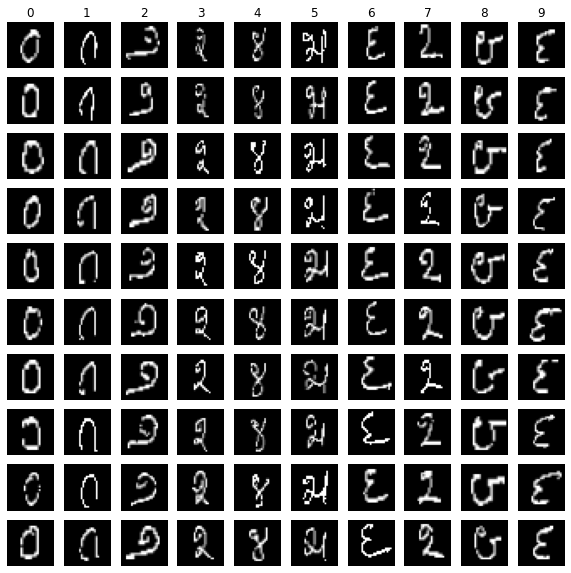

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

for i in range(10): # Column by column
    num_i = df_train.iloc[:,1:][df_train.iloc[:,0] == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

Distribución de las clases

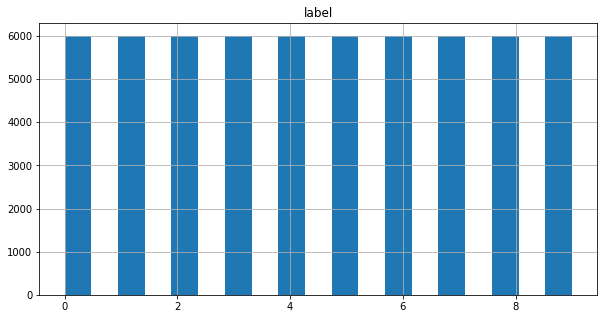

In [ ]:
df_train.hist(column='label',bins=19,figsize=(10,5));

#Dataloaders y funciones

In [ ]:
class DatasetMNIST(Dataset):
    
    def __init__(self, dataset, transform=None):
        self.data = dataset #pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
# Put some augmentation on training data
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    torchvision.transforms.Pad(padding=2),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

# Test data without augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [ ]:
train_set = DatasetMNIST(df_train, transform=train_transform )

test_set = DatasetMNIST(df_test, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
valid_set_size = 6000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 54000
Tamaño del conjunto de validación: 6000


In [ ]:
valid_loader  = torch.utils.data.DataLoader(valid_set, batch_size = BATCH_SIZE, shuffle = True)

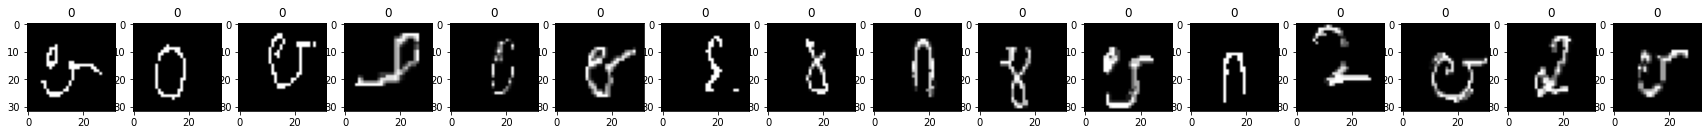

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap='gray')
    break

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

#LeNet-5

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding='valid')
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding='valid')
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding='valid')
        self.fc1 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = LeNet5()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [ ]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

conv_model_loss = torch.nn.CrossEntropyLoss()

In [ ]:
result_model, history = train(conv_model, conv_model_loss, conv_model_optimizer, train_loader, valid_loader, 10)

Epoch: 1/10 - Train loss 0.348417 - Train Accuracy 0.888250 - Valid Loss 0.146153 - Valid Accuracy 0.955618
Epoch: 2/10 - Train loss 0.114308 - Train Accuracy 0.963917 - Valid Loss 0.094452 - Valid Accuracy 0.970412
Epoch: 3/10 - Train loss 0.085724 - Train Accuracy 0.972900 - Valid Loss 0.091284 - Valid Accuracy 0.968916
Epoch: 4/10 - Train loss 0.073860 - Train Accuracy 0.977117 - Valid Loss 0.066263 - Valid Accuracy 0.979555
Epoch: 5/10 - Train loss 0.064361 - Train Accuracy 0.979767 - Valid Loss 0.057356 - Valid Accuracy 0.982547
Epoch: 6/10 - Train loss 0.061053 - Train Accuracy 0.980700 - Valid Loss 0.058776 - Valid Accuracy 0.981383
Epoch: 7/10 - Train loss 0.054240 - Train Accuracy 0.982683 - Valid Loss 0.044140 - Valid Accuracy 0.984375
Epoch: 8/10 - Train loss 0.051150 - Train Accuracy 0.983433 - Valid Loss 0.050026 - Valid Accuracy 0.985040
Epoch: 9/10 - Train loss 0.051586 - Train Accuracy 0.983333 - Valid Loss 0.045446 - Valid Accuracy 0.984541
Epoch: 10/10 - Train loss 0.

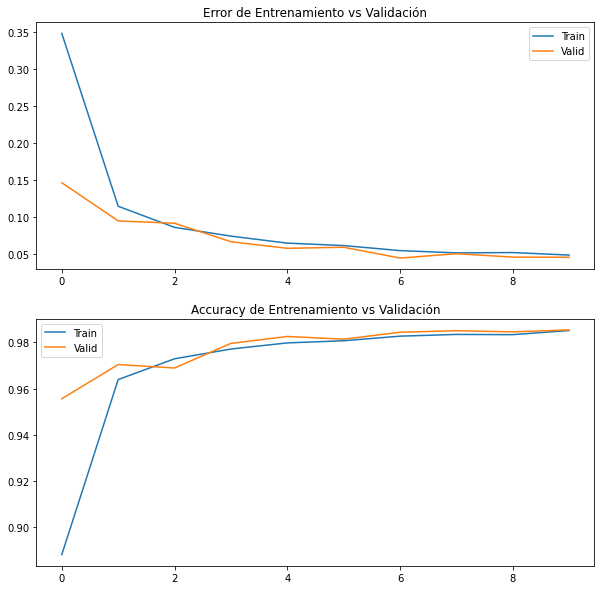

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

# Vgg19

In [ ]:
# Mantenemos las mismas técnicas de data augmentation pero escalamos las imágenes a 224x224 tal y como lo recomienda pytorch en modelos pre entrenados
data_transforms = torchvision.transforms.Compose([
                    transforms.ToPILImage(),
                    torchvision.transforms.Resize(size=(224, 224)),
                    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
                    transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor(),
                  ])

In [ ]:
# Creamos los nuevos data loaders

train_set = DatasetMNIST(df_train, transform = data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)

valid_set_size = 6000
train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
# Carga de modelo base

vgg19_model = torchvision.models.vgg19(pretrained=True)
vgg19_model.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [ ]:
# Cambiamos la entrada en la primera capa, ya que el modelo original espera 3 canales y nuestra imágenes son de un solo canal
vgg19_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3), stride=1, padding=1)

In [ ]:
# Cambiamos la última capa ya entrenar un clasificador con 10 posibles salidad
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [ ]:
vgg19_model.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [ ]:
vgg19_model  = vgg19_model.to("cuda")
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
torchsummary.summary(vgg19_model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
result_model, history = train(vgg19_model, criterion, optimizer_ft, train_loader, valid_loader, 10)


Epoch: 1/10 - Train loss 0.852050 - Train Accuracy 0.716700 - Valid Loss 0.379118 - Valid Accuracy 0.896609
Epoch: 2/10 - Train loss 0.446225 - Train Accuracy 0.850300 - Valid Loss 0.275322 - Valid Accuracy 0.916556
Epoch: 3/10 - Train loss 0.390528 - Train Accuracy 0.868433 - Valid Loss 0.228517 - Valid Accuracy 0.934009
Epoch: 4/10 - Train loss 0.363652 - Train Accuracy 0.877050 - Valid Loss 0.214399 - Valid Accuracy 0.938996
Epoch: 5/10 - Train loss 0.339461 - Train Accuracy 0.885017 - Valid Loss 0.193651 - Valid Accuracy 0.945645
Epoch: 6/10 - Train loss 0.327470 - Train Accuracy 0.889100 - Valid Loss 0.186184 - Valid Accuracy 0.947640
Epoch: 7/10 - Train loss 0.320957 - Train Accuracy 0.892100 - Valid Loss 0.184856 - Valid Accuracy 0.942487
Epoch: 8/10 - Train loss 0.306533 - Train Accuracy 0.897350 - Valid Loss 0.170451 - Valid Accuracy 0.952128
Epoch: 9/10 - Train loss 0.306022 - Train Accuracy 0.897583 - Valid Loss 0.164334 - Valid Accuracy 0.950465
Epoch: 10/10 - Train loss 0.

#ResNet

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

In [ ]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(3), stride=1, padding=1) 

In [ ]:
model.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [ ]:
model = model.to("cuda")

In [ ]:
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,864
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
       BasicBlock-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,864
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

In [ ]:
model_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# train
epochs = 10
result_model, history = train(model, model_loss, optimizer, train_loader, valid_loader, epochs)

Epoch: 1/10 - Train loss 0.128766 - Train Accuracy 0.964167 - Valid Loss 0.074324 - Valid Accuracy 0.979388
Epoch: 2/10 - Train loss 0.060766 - Train Accuracy 0.983250 - Valid Loss 0.037138 - Valid Accuracy 0.989528
Epoch: 3/10 - Train loss 0.050075 - Train Accuracy 0.986383 - Valid Loss 0.019426 - Valid Accuracy 0.994681
Epoch: 4/10 - Train loss 0.040082 - Train Accuracy 0.988933 - Valid Loss 0.016700 - Valid Accuracy 0.995013
Epoch: 5/10 - Train loss 0.035048 - Train Accuracy 0.990567 - Valid Loss 0.021462 - Valid Accuracy 0.993850
Epoch: 6/10 - Train loss 0.034590 - Train Accuracy 0.990550 - Valid Loss 0.029121 - Valid Accuracy 0.991024
Epoch: 7/10 - Train loss 0.029235 - Train Accuracy 0.991600 - Valid Loss 0.032876 - Valid Accuracy 0.992354
Epoch: 8/10 - Train loss 0.024937 - Train Accuracy 0.992833 - Valid Loss 0.013750 - Valid Accuracy 0.996177
Epoch: 9/10 - Train loss 0.022317 - Train Accuracy 0.993550 - Valid Loss 0.013723 - Valid Accuracy 0.995844
Epoch: 10/10 - Train loss 0.

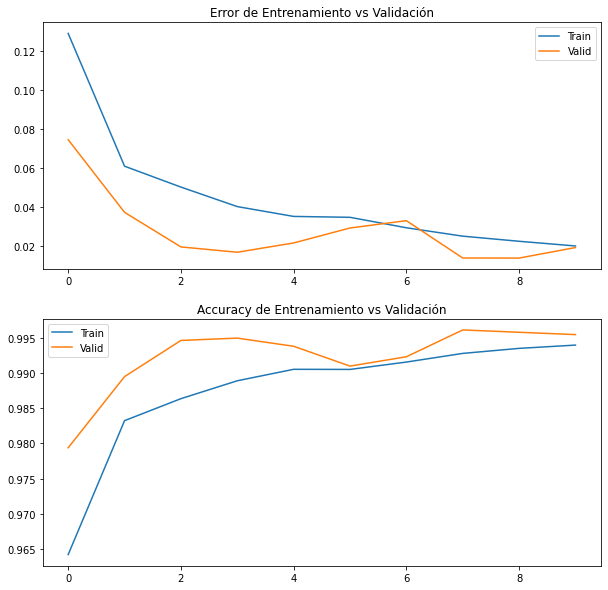

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])